
<img src="../../img/ods_stickers.jpg">

## <center> [mlcourse.ai](https://mlcourse.ai) – открытый курс OpenDataScience по машинному обучению 
    
Автор материала: Виталий Радченко, Data scientist @ YouScan (@vradchenko в Slack ODS). Материал распространяется на условиях лицензии [Creative Commons CC BY-NC-SA 4.0](https://creativecommons.org/licenses/by-nc-sa/4.0/). Можно использовать в любых целях (редактировать, поправлять и брать за основу), кроме коммерческих, но с обязательным упоминанием автора материала

# <center> Домашнее задание № 5 (Демо).
## <center> Логистическая регрессия и случайный лес в задаче кредитного скоринга

[Веб-форма](https://docs.google.com/forms/d/1HASy2b_FLBHBCzzpG-TbnbB6gqhB-qwznQxU2vaoSgc/) для ответов.

#### Нашей главной задачей будет построение модели для задачи кредитного скоринга.

Но для разминки решите первое задание :)

**Задание 1.** В зале суда есть 5 присяжных, каждый из них по отдельности с вероятностью 70% может правильно определить, виновен подсудимый или нет. С какой вероятностью они все вместе вынесут правильный вердикт, если решение принимается большинством голосов?
- 70.00%
- 83.20%
- 83.70%
- 87.50%

Теперь перейдем непосредственно к машинному обучению.

#### Данные представлены следующим образом:

##### Прогнозируемая  переменная
* SeriousDlqin2yrs	      – Человек не выплатил данный кредит в течение 90 дней; возможные значения  1/0 

##### Независимые признаки
* age	                          –  Возраст заёмщика кредитных средств; тип - integer
* NumberOfTime30-59DaysPastDueNotWorse	 – Количество раз, когда человек имел просрочку выплаты других кредитов более 30-59 дней, но не больше в течение последних двух лет; тип -	integer
* DebtRatio  – 	Ежемесячный отчисления на задолжености(кредиты,алименты и т.д.)  / совокупный месячный доход 	percentage; тип -	real
* MonthlyIncome	 – Месячный доход в долларах; тип -	real
* NumberOfTimes90DaysLate  – Количество раз, когда человек имел просрочку выплаты других кредитов более 90 дней; тип -	integer
* NumberOfTime60-89DaysPastDueNotWorse – 	Количество раз, когда человек имел просрочку выплаты других кредитов более 60-89 дней, но не больше в течение последних двух лет; тип -	integer
* NumberOfDependents  – Число человек в семье кредитозаёмщика; тип -	integer

In [6]:
%matplotlib inline
# отключим предупреждения Anaconda
import warnings

import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd

In [7]:
## Сделаем функцию, которая будет заменять NaN значения на медиану в каждом столбце таблицы
def delete_nan(table):
    for col in table.columns:
        table[col] = table[col].fillna(table[col].median())
    return table

In [8]:
## Считываем данные
data = pd.read_csv("../../../data/credit_scoring_sample.csv", sep=";")
data.head()

,SeriousDlqin2yrs,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,NumberOfTimes90DaysLate,NumberOfTime60-89DaysPastDueNotWorse,MonthlyIncome,NumberOfDependents
0,0,64,0,0.249908,0,0,8158.0,0.0
1,0,58,0,3870.000000,0,0,NaN,0.0
2,0,41,0,0.456127,0,0,6666.0,0.0
3,0,43,0,0.000190,0,0,10500.0,2.0
4,1,49,0,0.271820,0,0,400.0,0.0


In [9]:
## Рассмотрим типы считанных данных
data.dtypes

SeriousDlqin2yrs                          int64
age                                       int64
NumberOfTime30-59DaysPastDueNotWorse      int64
DebtRatio                               float64
NumberOfTimes90DaysLate                   int64
NumberOfTime60-89DaysPastDueNotWorse      int64
MonthlyIncome                           float64
NumberOfDependents                      float64
dtype: object

Distribution of target


0    0.777511
1    0.222489
Name: SeriousDlqin2yrs, dtype: float64

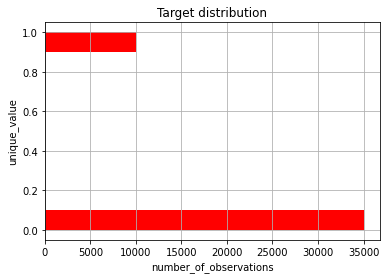

In [10]:
## Посмотрим на распределение классов в зависимой переменной

ax = data["SeriousDlqin2yrs"].hist(orientation="horizontal", color="red")
ax.set_xlabel("number_of_observations")
ax.set_ylabel("unique_value")
ax.set_title("Target distribution")

print("Distribution of target")
data["SeriousDlqin2yrs"].value_counts() / data.shape[0]

In [11]:
## Выберем названия всех признаков из таблицы, кроме прогнозируемого

independent_columns_names = data.columns.values
independent_columns_names = [x for x in data if x != "SeriousDlqin2yrs"]
independent_columns_names

['age',
 'NumberOfTime30-59DaysPastDueNotWorse',
 'DebtRatio',
 'NumberOfTimes90DaysLate',
 'NumberOfTime60-89DaysPastDueNotWorse',
 'MonthlyIncome',
 'NumberOfDependents']

In [12]:
## Применяем функцию, заменяющую все NaN значения на медианное значение соответствующего столбца
table = delete_nan(data)

In [13]:
## Разделяем таргет и признаки
X = table[independent_columns_names]
y = table["SeriousDlqin2yrs"]

# Бутстрэп

<AxesSubplot:>

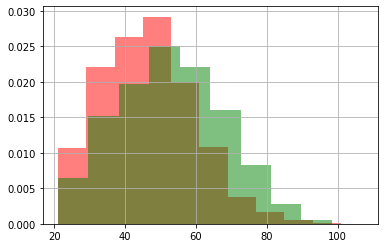

In [23]:
data.loc[data.SeriousDlqin2yrs == 1, 'age'].hist(alpha=0.5, color='red', density=1)
data.loc[data.SeriousDlqin2yrs == 0, 'age'].hist(alpha=0.5, color='green', density=1)

**Задание 2.** Сделайте интервальную оценку среднего возраста (age) для клиентов, которые просрочили выплату кредита, с 90% "уверенностью". Используйте пример из статьи, поставьте `np.random.seed(0)`, как это сделано в статье.

In [24]:
import numpy as np
def get_bootstrap_samples(data, n_samples):
    # функция для генерации подвыборок с помощью бутстрэпа
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples
def stat_intervals(stat, alpha):
    # функция для интервальной оценки
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [38]:
bad_age = data.loc[data.SeriousDlqin2yrs == 1, 'age'].values
bad_age_mean = [np.mean(sample) for sample in get_bootstrap_samples(bad_age, 1000)]
stat_intervals(bad_age_mean, 0.1)

array([45.71005386, 46.14176142])

## Подбор параметров для модели логистической регрессии 

#### Одной из важных метрик качества модели является значение площади под ROC-кривой. Значение ROC-AUC лежит от 0  до 1.   Чем ближе начение метрики ROC-AUC к 1, тем качественнее происходит классификация моделью.

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold

## Используем модуль LogisticRegression для построения логистической регрессии.
## Из-за несбалансированности классов  в таргете добавляем параметр балансировки.
## Используем также параметр random_state=5 для воспроизводимости результатов
lr = LogisticRegression(random_state=5, class_weight="balanced")

## Попробуем подобрать лучший коэффициент регуляризации (коэффициент C в логистической регрессии) для модели лог.регрессии.
## Этот параметр необходим для того, чтобы подобрать оптимальную модель, которая не будет переобучена, с одной стороны,
## и будет хорошо предсказывать значения таргета, с другой.
## Остальные параметры оставляем по умолчанию.
parameters = {"C": (0.0001, 0.001, 0.01, 0.1, 1, 10)}

## Для того, чтобы подобрать коэффициент регуляризации, попробуем для каждого его возможного значения посмотреть
## значения roc-auc на стрэтифайд кросс-валидации из 5 фолдов с помощью функции StratifiedKFold

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=5)

**Задание 3.**
Сделайте GridSearch с метрикой "roc-auc" по параметру C. Какое оптимальное значение параметра С?

In [114]:
model_grid = GridSearchCV(lr, scoring='roc_auc', cv=skf, param_grid=parameters, n_jobs=-1)
model_grid.fit(X, y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5, shuffle=True),
             estimator=LogisticRegression(class_weight='balanced',
                                          random_state=5),
             n_jobs=-1, param_grid={'C': (0.0001, 0.001, 0.01, 0.1, 1, 10)},
             scoring='roc_auc')

In [115]:
model_grid.best_params_, model_grid.best_score_

({'C': 0.001}, 0.8089120626797153)

In [118]:
model_grid.cv_results_['std_test_score'][1]

0.008137559189742445

In [116]:
model_grid.cv_results_

{'mean_fit_time': array([0.28913531, 0.25235415, 0.25358162, 0.29593391, 0.33660135,
        0.25432763]),
 'std_fit_time': array([0.04973135, 0.06836822, 0.0645087 , 0.05176659, 0.0689973 ,
        0.0683136 ]),
 'mean_score_time': array([0.01269331, 0.00977807, 0.00786381, 0.00780849, 0.01151719,
        0.00663533]),
 'std_score_time': array([0.00461362, 0.00297838, 0.00024347, 0.00034895, 0.00659615,
        0.00143473]),
 'param_C': masked_array(data=[0.0001, 0.001, 0.01, 0.1, 1, 10],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.0001},
  {'C': 0.001},
  {'C': 0.01},
  {'C': 0.1},
  {'C': 1},
  {'C': 10}],
 'split0_test_score': array([0.77984662, 0.80917719, 0.80929853, 0.79170083, 0.78384333,
        0.79174075]),
 'split1_test_score': array([0.78759234, 0.8179555 , 0.79419876, 0.79394568, 0.79514694,
        0.80495931]),
 'split2_test_score': array([0.78635422, 0.79530418, 0.79821275, 0.798

**Задание 4.** 
Можно ли считать лучшую модель устойчивой? (модель считаем устойчивой, если стандартное отклонение на валидации меньше 0.5%) Сохраните точность лучшей модели, она вам приходится для следующих заданий

In [119]:
scores = np.array([model_grid.cv_results_[f'split{i}_test_score'] for i in range(5)])
scores[:, 1].std()

0.008137559189742445

/Users/kremenevskiy/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kremenevskiy/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

[CV 4/5] END base_estimator__C=1, max_features=2, max_samples=0.9;, score=0.811 total time=   9.6s
[CV 2/5] END base_estimator__C=100, max_features=3, max_samples=0.5;, score=0.817 total time=  14.3s
[CV 5/5] END base_estimator__C=100, max_features=3, max_samples=0.5;, score=0.811 total time=  15.6s
[CV 4/5] END base_estimator__C=10, max_features=3, max_samples=0.7;, score=0.809 total time=  15.6s
[CV 4/5] END base_estimator__C=10, max_features=4, max_samples=0.9;, score=0.810 total time=  20.9s
[CV 3/5] END base_estimator__C=1, max_features=4, max_samples=0.5;, score=0.799 total time=  18.6s
[CV 2/5] END base_estimator__C=0.01, max_features=3, max_samples=0.5;, score=0.816 total time=  12.1s
[CV 5/5] END base_estimator__C=0.01, max_features=3, max_samples=0.5;, score=0.810 total time=  12.5s
[CV 5/5] END base_estimator__C=100, max_features=2, max_samples=0.9;, score=0.811 total time=   8.9s
[CV 4/5] END base_estimator__C=10, max_features=2, max_samples=0.7;, score=0.811 total time=   

/Users/kremenevskiy/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kremenevskiy/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

[CV 2/5] END base_estimator__C=1, max_features=2, max_samples=0.9;, score=0.817 total time=   9.5s
[CV 5/5] END base_estimator__C=1, max_features=2, max_samples=0.9;, score=0.811 total time=   4.6s
[CV 4/5] END base_estimator__C=100, max_features=3, max_samples=0.5;, score=0.809 total time=  15.0s
[CV 3/5] END base_estimator__C=10, max_features=3, max_samples=0.7;, score=0.800 total time=  15.4s
[CV 2/5] END base_estimator__C=10, max_features=4, max_samples=0.9;, score=0.817 total time=  21.6s
[CV 1/5] END base_estimator__C=1, max_features=4, max_samples=0.5;, score=0.803 total time=  20.2s
[CV 5/5] END base_estimator__C=1, max_features=4, max_samples=0.5;, score=0.809 total time=  17.4s
[CV 4/5] END base_estimator__C=0.01, max_features=3, max_samples=0.5;, score=0.808 total time=  12.7s
[CV 3/5] END base_estimator__C=100, max_features=2, max_samples=0.9;, score=0.800 total time=   8.7s
[CV 2/5] END base_estimator__C=10, max_features=2, max_samples=0.7;, score=0.817 total time=   9.3s


/Users/kremenevskiy/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/kremenevskiy/opt/anaconda3/envs/ML/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/m

## Определение влияния признаков

**Задание 5.**
Определите самый важный признак. Важность признака определяется абсолютным значением его коэффициента. Так же нужно нормализировать все признаки, что бы можно их было корректно сравнить.

In [14]:
from sklearn.preprocessing import StandardScaler

In [15]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
lr = LogisticRegression(C=0.001, random_state=5, class_weight='balanced')
lr.fit(X_scaled, y)
coefs = pd.DataFrame(lr.coef_.T, index=X.columns, columns=['coef'])\
            .sort_values(by='coef', ascending=False)
coefs

,coef
NumberOfTime30-59DaysPastDueNotWorse,0.723427
NumberOfTimes90DaysLate,0.516788
NumberOfTime60-89DaysPastDueNotWorse,0.193558
NumberOfDependents,0.101443
DebtRatio,-0.024096
MonthlyIncome,-0.163146
age,-0.416702


**Задание 6.** Посчитайте долю влияния DebtRatio на предсказание. (Воспользуйтесь функцией [softmax](https://en.wikipedia.org/wiki/Softmax_function))

In [16]:
def soft_max(arr, index):
    return np.exp(arr[index]) / sum([np.exp(x) for x in arr])

In [17]:
soft_max(coefs['coef'], 4)

0.11426375283065265

**Задание 7.** 
Давайте посмотрим как можно интерпретировать влияние наших признаков. Для этого заного оценим логистическую регрессию в абсолютных величинах. После этого посчитайте во сколько раз увеличатся шансы, что клиент не выплатит кредит, если увеличить возраст на 20 лет при всех остальных равных значениях признаков. (теоретический расчет можно посмотреть [здесь](https://www.unm.edu/~schrader/biostat/bio2/Spr06/lec11.pdf))

In [18]:
lr = LogisticRegression(C=0.001, random_state=5, class_weight='balanced')
lr.fit(X, y)
pd.DataFrame({'feat': X.columns, 'coef':lr.coef_.flatten()}).sort_values(by='coef', ascending=False)

,feat,coef
1,NumberOfTime30-59DaysPastDueNotWorse,0.446832
3,NumberOfTimes90DaysLate,0.390381
4,NumberOfTime60-89DaysPastDueNotWorse,0.216038
6,NumberOfDependents,0.191726
2,DebtRatio,-0.000006
5,MonthlyIncome,-0.000011
0,age,-0.013656


In [24]:
np.exp(lr.coef_[0][0]*20)

0.7610087032391873

# Случайный лес

In [93]:
from sklearn.ensemble import RandomForestClassifier

# Инициализируем случайный лес с 100 деревьями и сбалансированными классами
rf = RandomForestClassifier(
    n_estimators=100,
    n_jobs=-1,
    random_state=42,
    oob_score=True,
    class_weight="balanced",
)

## Будем искать лучшие параметры среди следующего набора
parameters = {
    "max_features": [1, 2, 4],
    "min_samples_leaf": [3, 5, 7, 9],
    "max_depth": [5, 10, 15],
}

## Делаем опять же стрэтифайд k-fold валидацию. Инициализация которой должна у вас продолжать храниться в skf

**Задание 8.** На сколько точность лучшей модели случайного леса выше точности логистической регрессии на валидации?

In [94]:
%%time
forest_grid = GridSearchCV(rf, param_grid=parameters, cv=skf, scoring='roc_auc')
forest_grid.fit(X, y)

CPU times: user 1min 44s, sys: 10.1 s, total: 1min 54s
Wall time: 4min 27s


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5, shuffle=True),
             estimator=RandomForestClassifier(class_weight='balanced',
                                              n_jobs=-1, oob_score=True,
                                              random_state=42),
             param_grid={'max_depth': [5, 10, 15], 'max_features': [1, 2, 4],
                         'min_samples_leaf': [3, 5, 7, 9]},
             scoring='roc_auc')

In [98]:
forest_grid.best_params_, forest_grid.best_score_

({'max_depth': 10, 'max_features': 2, 'min_samples_leaf': 9},
 0.8357785451032532)

**Задание 9.** Определите какой признак имеет самое слабое влияние.

In [99]:
forest_coefs = pd.DataFrame(abs(forest_grid.best_estimator_.feature_importances_.T), index=X.columns, columns=['coef'])\
            .sort_values(by='coef', ascending=False)
forest_coefs

,coef
NumberOfTime30-59DaysPastDueNotWorse,0.300290
NumberOfTimes90DaysLate,0.278749
NumberOfTime60-89DaysPastDueNotWorse,0.156534
age,0.115860
DebtRatio,0.076082
MonthlyIncome,0.057994
NumberOfDependents,0.014491


** Задание 10.** Какое наиболее существенное примущество логистической регрессии перед случайным лесом для нашей бизнес-задачи?

- меньше тратится времени для тренировки модели;
- меньше параметров для перебора;
- интепретируемость признаков;
- линейные свойства алгоритма.

# Бэггинг

In [100]:
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import RandomizedSearchCV

parameters = {
    "max_features": [2, 3, 4],
    "max_samples": [0.5, 0.7, 0.9],
    "base_estimator__C": [0.0001, 0.001, 0.01, 1, 10, 100],
}

**Задание 11.** Следующая задача обучить бэггинг классификатор (`random_state`=42). В качестве базовых классификаторов возьмите 100 логистических регрессий и на этот раз используйте не `GridSearchCV`, а `RandomizedSearchCV`. Так как перебирать все 54 варианта комбинаций долго, то поставьте максимальное число итераций 20 для `RandomizedSearchCV`. Также не забудьте передать параметр валидации `cv` и `random_state=1`. Какая лучшая точность получилась?

In [110]:
%%time
classifier_bag = BaggingClassifier(LogisticRegression(random_state=42, class_weight='balanced'), random_state=42, n_estimators=100)
bagging_cl_grid = RandomizedSearchCV(classifier_bag, scoring='roc_auc', n_iter=20, param_distributions=parameters, n_jobs=-1, verbose=3)
bagging_cl_grid.fit(X, y)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
CPU times: user 10.4 s, sys: 954 ms, total: 11.3 s
Wall time: 5min 51s


RandomizedSearchCV(estimator=BaggingClassifier(base_estimator=LogisticRegression(class_weight='balanced',
                                                                                 random_state=42),
                                               n_estimators=100,
                                               random_state=42),
                   n_iter=20, n_jobs=-1,
                   param_distributions={'base_estimator__C': [0.0001, 0.001,
                                                              0.01, 1, 10,
                                                              100],
                                        'max_features': [2, 3, 4],
                                        'max_samples': [0.5, 0.7, 0.9]},
                   scoring='roc_auc', verbose=3)

In [111]:
bagging_cl_grid.best_params_, bagging_cl_grid.best_score_

({'max_samples': 0.5, 'max_features': 2, 'base_estimator__C': 10},
 0.80981798187848)

**Задача 12.** Дайте интерпретацию лучших параметров для бэггинга. Почему именно такие значения оказались лучшими?

- для бэггинга важно использовать как можно меньше признаков
- бэггинг лучше работает на небольших выборках
- меньше корреляция между одиночными моделями
- чем больше признаков, тем меньше теряется информации